<a href="https://colab.research.google.com/github/vprobon/LIRcentral_curation_tools/blob/main/LIR_papers_MLscreen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIR_papers_MLscreen.ipynb

## A simple literature analysis-assistant for LIRcentral curators.

Based on code and ideas presented in https://github.com/pacejohn/Text_Classification_Pubmed_Abstracts/tree/main

LIR motif bibliography data gathered based on the LIRcentral database (https://lircentral.eu) and code by Maria Erodotou.


# Description
Labeled abstracts are expected in a comma-separated file (fields: text, label).

Text is read in a pandas dataframe and preprocessed using NLTK functionalities (e.g stemming, lemmatization). Use of different options can yield different results. It is crucial to test the classifiers' perfomance as soon as large chunks of new papers in the less populated positive class are available. TF-IDF vectors are created to use as input and can be tested with different classifiers.

In our experiments we found a very simple Naive Bayes classifier to work best compared to other more sophisticated/complex classifiers (RF, Boosting).

**Note:** Due to the heavily imballanced nature of the datasets, we find that it is important
- To downsample the class of negative examples
- To prefer classifiers that go for higher recall (sensitivity) instead of other performance metrics.This is the only way to ensure that as little as possible relevant papers for curation are missed.
- A trick for more complex classifiers to work at an acceptable level is to 'infuse' the corpus with documents unrelated to autophagy. However, this feature has not been extensively tested and should be considered as experimental.
- Other vectorization/stemming/lemmatizing approaches can be used. The code below provides a template for testing any other sort of transformations.


# Grab corpus (if necessary) or upload your own data

**Note:** Modify the text below so that the final corpus file is named all_combined_abstracts.csv

In [ ]:
# Grab corpus (if necessary) or upload your own data
# ! wget https://github.com/pacejohn/Text_Classification_Pubmed_Abstracts/raw/main/all_combined_abstracts.zip
# ! unzip "/content/all_combined_abstracts.zip"

#!cat custom.csv "all_combined_abstracts 2.csv" > all_combined_abstracts.csv
# Where custom.csv is a user-provided corpus
#!cp custom.csv all_combined_abstracts.csv

In [ ]:
# Check corpus file reads ok
!head all_combined_abstracts.csv


# Import libraries

In [ ]:
# Imports
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from termcolor import colored

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB


# Variables
num_features_to_display = 20


# Read the corpus and generate descriptive statistics

Count of each class of abstract:
abstract_class
Autophagy_LIR        147
Autophagy_notLIR    1397
Name: count, dtype: int64


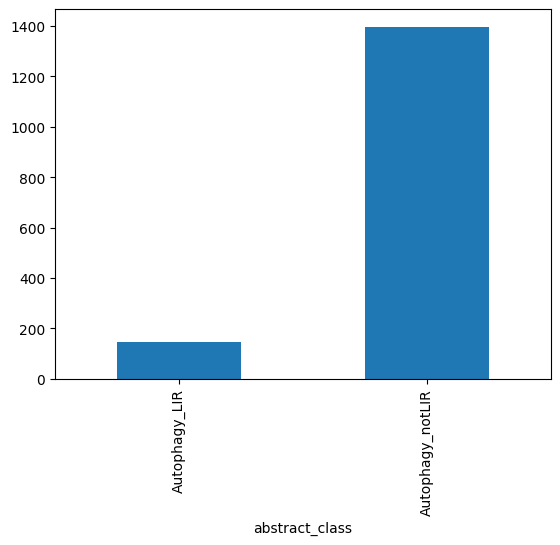

In [7]:
# Read the input files with the abstracts for train/test
pubmed = pd.read_csv("all_combined_abstracts.csv", header=None)
pubmed.columns = ["abstract_text", "abstract_class"]
X, y = pubmed["abstract_text"], pubmed["abstract_class"]

# Some descriptive stats on the abstract
# Count of each class of abstract
print(colored("Count of each class of abstract:", "red"))
print(pubmed.abstract_class.value_counts().sort_values(ascending=True))

# Print bar chart with values for each class
pubmed.abstract_class.value_counts().sort_values(ascending=True).plot.bar()
plt.show()

# Post-process the corpus.
## Here is a good place to experiment with different options.

In [8]:
# processed_abstracts will be the list of all the processed abstracts
processed_abstracts = []

# Instantiate lemmatizer and stemmer
wnlemmatizer = WordNetLemmatizer()
# For invoking Stemming
stemming = False # Set to True if stemming needs to be performed
if stemming == True:
  ps = PorterStemmer()

# Loop through all abstracts and pre-process
for abstract in X:
    # Convert to Lowercase
    abstract = abstract.lower()

    # Replace section names
    section_names = ["AIM: ", "OBJECTIVE: ", "RESULTS: ", "OBJECTIVES: ", "SELECTION: ", "PURPOSE: ",
                    "INTRODUCTION: ", "METHODS: ", "CONCLUSIONS: ", "MATERIALS AND METHODS: ",
                    "BACKGROUND: ", "CASE DESCRIPTION: ", "CLINICAL SIGNIFICANCE: ",
                    "STUDY DESIGN: ", "CONCLUSION: "]
    for section in section_names:
        abstract = abstract.replace(section.lower(), "")

    # Replace periods and double spaces
    abstract = abstract.replace(".  ", " ").replace(". ", " ").replace("  ", " ")

    # Remove all the special characters
    abstract = re.sub(r'\W', ' ', abstract)

    # Remove all numbers except those appearing in words, such as APOBEC3
    abstract = re.sub(r'\b\d+\b', ' ', abstract)

    # Lemmatatize words
    abstract = word_tokenize(abstract)

    # Remove short words
    # WARNING: in some applications (LIR-motif related papers) the corpus
    # contains short words of particular importance (e.g. LIR, LRS, LC3)
    abstract = ' '.join([word for word in abstract if len(word)>2])

    abstract = ''.join([wnlemmatizer.lemmatize(word) for word in abstract])

    # For the LIRcentral corpus, stemming deteriorates performance
    # so this option is turned off by default.
    if stemming == True:
      abstract = ''.join([ps.stem(word) for word in abstract])

    processed_abstracts.append(abstract)

# Encode the corpus texts by applying simple TF-IDF vectorization while removing non-informative stop-words

**Note:** Consider using customized stopword lists after inspecting important features of the datasets.



In [9]:
# Perform TF-IDF vectorization, removing stopwords
# Instantiate vectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
# Transform X for training
X = tfidfconverter.fit_transform(processed_abstracts).toarray()
# Get the feature names to be used later for feature importance
# vprobon: this does not work with newer versions sklearn.__version__ >= 0.24.x
#feature_name_list = tfidfconverter.get_feature_names()
feature_name_list = tfidfconverter.get_feature_names_out()


# Time for some machine learning

In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Starting with a very simple Naive Bayes model (BernouliNB), suitable for categorical output/prediction.


Accuracy: 0.95146 

Classification Report:
                  precision    recall  f1-score   support

   Autophagy_LIR       0.70      0.94      0.81        33
Autophagy_notLIR       0.99      0.95      0.97       276

        accuracy                           0.95       309
       macro avg       0.85      0.95      0.89       309
    weighted avg       0.96      0.95      0.95       309

Confusion Matrix:


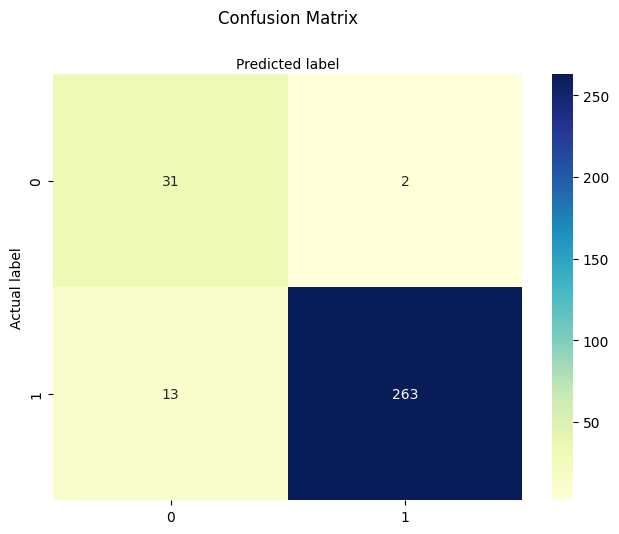

In [11]:
## Initialize the Bernoulli Naive Bayes classifier

bern = BernoulliNB()
bern.fit(X_train, y_train)

y_pred = bern.predict(X_test)

print("\nAccuracy: %.5f " % (accuracy_score(y_test, y_pred)))

print(colored("\nClassification Report:", "red"))
print(classification_report(y_test,y_pred))

print(colored("Confusion Matrix:", "red"))
# Prepare the plot
fig, ax = plt.subplots()
tick_marks = np.arange(len(bern.classes_))
plt.xticks(tick_marks, bern.classes_)
plt.yticks(tick_marks, bern.classes_)

# Create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Naive Bayes works excellent!
Now properly evaluate the model using cross-validation


Cross-Validation Accuracy Scores:  [0.94498382 0.89644013 0.91909385 0.93203883 0.93181818]
Mean Cross-Validation Accuracy: 0.92487

Classification Report:
                  precision    recall  f1-score   support

   Autophagy_LIR       0.57      0.88      0.69       147
Autophagy_notLIR       0.99      0.93      0.96      1397

        accuracy                           0.92      1544
       macro avg       0.78      0.90      0.82      1544
    weighted avg       0.95      0.92      0.93      1544

Confusion Matrix:


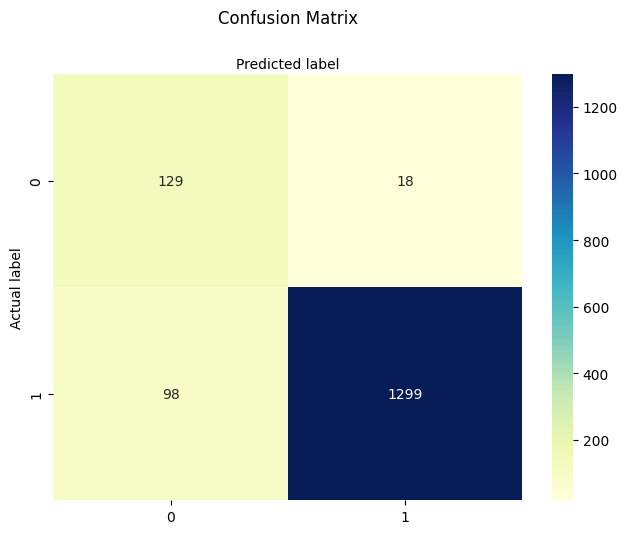

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from termcolor import colored

# Initialize the Bernoulli Naive Bayes classifier
bern = BernoulliNB()

# Define 5-fold cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross validation accuracy scores
cv_scores = cross_val_score(bern, X, y, cv=kf, scoring='accuracy')
print("\nCross-Validation Accuracy Scores: ", cv_scores)
print("Mean Cross-Validation Accuracy: %.5f" % np.mean(cv_scores))

# Cross validation predictions
y_pred = cross_val_predict(bern, X, y, cv=kf)

# Print classification report
print(colored("\nClassification Report:", "red"))
print(classification_report(y, y_pred))

# Print confusion matrix
print(colored("Confusion Matrix:", "red"))

# Prepare the plot
fig, ax = plt.subplots()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))

# Create heatmap
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# Other classifier options

In case one needs to test other machine learning classifiers (e.g. Random Forest).

## A Random Forest classifier

Feature Importance
interacting: 0.04494
lir: 0.04122
motif: 0.03341
region: 0.03234
atg8: 0.02874
interacts: 0.02304
lc3: 0.01938
gabarap: 0.01849
binds: 0.01798
binding: 0.01747
interaction: 0.01636
cargo: 0.01364
sequence: 0.01112
interact: 0.01075
selective: 0.00986
motifs: 0.00939
receptors: 0.00775
receptor: 0.00774
lc3c: 0.00730
proteins: 0.00726
family: 0.00716


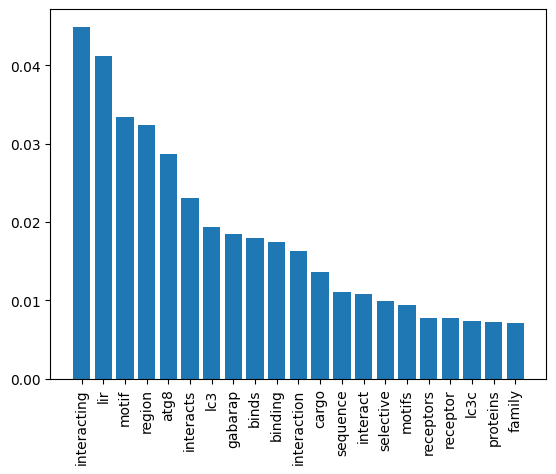

In [18]:
# Instantiate classifier with mostly default hyperparameters
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# Fit classifier
rf_classifier.fit(X_train, y_train)

# Print feature importance for features over a certain threshold
features_dict = {}
for i,v in enumerate(rf_classifier.feature_importances_):
    features_dict[v] = feature_name_list[i]

# Print sorted list of values
print(colored("Feature Importance", "red"))
i = 0
small_features_dict = {}
for key in sorted(features_dict, reverse=True):
    if i <= num_features_to_display:
        print("%s: %.5f" % (features_dict[key], key))
        small_features_dict[features_dict[key]] = key
        i += 1

# Plot feature importance variables
plt.bar(small_features_dict.keys(), small_features_dict.values())
plt.xticks(rotation='vertical')
plt.show()

In [19]:
# Run prediction on test set
y_pred = rf_classifier.predict(X_test)


Accuracy: 0.94498 

Classification Report:
                  precision    recall  f1-score   support

   Autophagy_LIR       0.94      0.52      0.67        33
Autophagy_notLIR       0.95      1.00      0.97       276

        accuracy                           0.94       309
       macro avg       0.94      0.76      0.82       309
    weighted avg       0.94      0.94      0.94       309

Confusion Matrix:


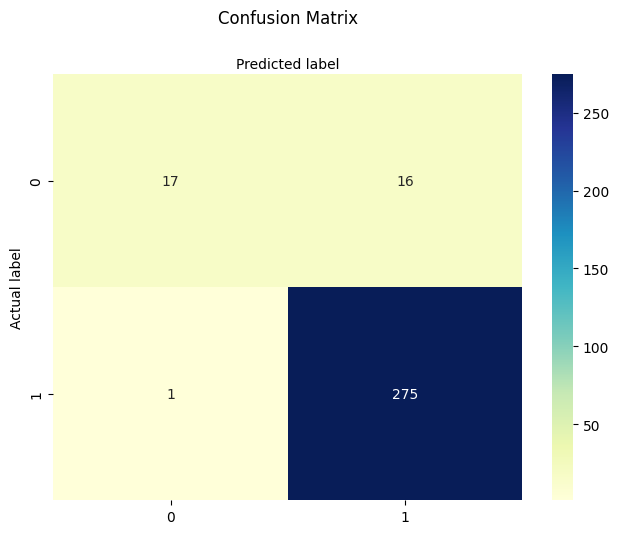

In [20]:
# Print the metrics

print("\nAccuracy: %.5f " % (accuracy_score(y_test, y_pred)))

print(colored("\nClassification Report:", "red"))
print(classification_report(y_test,y_pred))

print(colored("Confusion Matrix:", "red"))
# Prepare the plot
fig, ax = plt.subplots()
tick_marks = np.arange(len(rf_classifier.classes_))
plt.xticks(tick_marks, rf_classifier.classes_)
plt.yticks(tick_marks, rf_classifier.classes_)

# Create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [21]:
# Predict on unseen data, one for each category
dental_caries_prediction = "Aim: The aim of the study was to measure the efficiency of printed health education matters with reference to caries prevention and the endurance of knowledge acquired. Material and methods: The study included 74 parents of children coming from three kindergartens in the town of Plovdiv. Results: The results showed that the information was received well by the parents (86.2% correct answers). The repeated test after 6 months showed worse results than those from the first test, with an increase of the wrong answers (1st test - 14 wrong and 36 incomplete answers; 2nd test - 29 wrong and 44 incomplete answers). Conclusions: The information in this form is received well by the parents but requires periodic repetition for the purpose of assimilating the newly-acquired knowledge"
dental_pulp_prediction = "The correlation between reduction of the coronal pulp cavity and chronological age was examined in a sample of 846 intact teeth from 433 individuals of known age and sex. Panoramic (rotational) radiography was used to measure the height (mm) of the crown (CH = coronal height) and the height (mm) of the coronal pulp cavity (CPCH = coronal pulp cavity height) of 425 premolars and 421 molars from 213 males and 220 females. The tooth-coronal index (TCI) after Ikeda et al. [1985] Jpn. J. For. Med. 39:244-250) was computed for each tooth and regressed on real age. The correlation coefficients ranged from -0.92 (molars, combined sample, right side) to -0.87 (female molars), with an S.E. of the estimate ranging from 5.88-6.66 years. Correlations were slightly higher in males than females. The equations obtained allowed estimation of age in a sample of 100 teeth from both sexes (not used for the regression) with an error of +/- 5 years in 81.4% of cases for male molars. The regression formulae for estimating age obtained from the recent sample were tested on a historical sample of 100 teeth from 100-year-old skeletons with an error of +/- 5 years in 70.3% of cases for male molars. This study illustrates the potential value of a little-known aging method which can be easily applied to estimate age in both living individuals and skeletal material of unknown age."
endodontic_treatment_prediction = "Purpose: To evaluate 1) if glass ionomer interim temporary restorations (ITR) placed for 1-3 months prior to vital pulp therapy (VPT) improved accuracy of diagnosing the pulp's clinical status and subsequent VPT success, and 2) the effect of the location of the carious lesion on VPT. Methods: Primary molars (N=117) receiving pulp therapy with or without ITR were evaluated retrospectively. All teeth had caries extending >50 percent into dentin; caries lesion location was identified (proximal or non-proximal). Two examiners rated pulp status assessment, caries location, and pulp treatment, and correlated treatment outcomes after a mean of 34.7 months to these factors. Results: VPT failed more often in first primary molars (P<.001) than in second primary molars. Using ITR improved diagnosis of the pulp status, clinical success of VPT, (P=.013) and first molar VPT success (P=.02). First primary molars had more proximal lesions than second molars (P<.001). Failure of VPT was greater for teeth with proximal lesions (P=.03). Use of ITR significantly improved VPT in teeth with proximal lesions (P=.007) but not non-proximal lesions (P=.38). Conclusions: ITR placed prior to VPT improved pulpal diagnosis and VPT outcomes. Vital pulp therapy was less successful in primary molars with proximal lesions, and ITR significantly improved the success."
periodontal_disease_prediction = "The clinical effects of systemic penicillin and erythromycin on the periodontium were investigated. There are only a few studies of the effects of these antibiotics on clinical periodontal parameters. Of the 72 subjects in the study, 24 belonged to the penicillin group, 21 to the erythromycin group and 27 to the control group. Plaque and gingival indices, tooth mobility, and probing depths of gingival pockets were recorded before the drug treatment. Radiographs were taken. Both antibiotics decreased plaque, and erythromycin also decreased gingivitis. In the penicillin group 10 of the 24 patients developed abscesses during the study, and the studied clinical parameters worsened. These patients had more severe periodontitis initially than the persons with no acute reaction. The clinical changes had returned to the baseline level by 12 weeks after the antibiotic treatments. There were no significant or lasting effects of antibiotic treatment alone in patients with overt periodontitis."
transposable_elements_prediction = "The genetic determination of the control of resistance or susceptibility to germ line changes mediated by P elements was studied in two strains and in derivatives of crosses between them. One strain, characterized as true M, completely lacked P elements. The second strain, pseudo-M (M'), carried a number of P elements, but these did not have the potential to induce the gonadal sterility that is associated with P-M hybrid dysgenesis. Individuals from the true M strain were invariably unable to suppress P factor activity (i.e., all daughters of outcrosses of M females and P males were sterile). In contrast, individuals from the M' strain showed variable degrees of suppression that were manifested in a wide range of gonadal sterility frequencies in standard tests. This continuous distribution pattern was reproducible for more than 25 generations.--The results of the genetic analysis indicate that a strain with a variable degree of suppression of gonadal dysgenesis is not necessarily in a transient state between the extreme conditions of P and M cytotype. A large variance in the ability to suppress gonadal dysgenesis with a mean value intermediate between the extremes of P and M cytotype may be a relatively stable strain characteristic. No reciprocal cross effect was observed in the suppression of sterility of F1 females from M X M' matings. Thus, the existence of M' strains indicates a Mendelian component in P element regulation and suggests that cytotype, which has an extrachromosomal aspect, may be only one of perhaps several mechanisms involved in regulation. Analysis of the effects of individual chromosomes from the M' strain showed that each chromosome contributed to the reduction of gonadal dysgenesis in the progeny of test matings. The results are consistent with a one-component titration model for P element regulation."
combined_prediction = transposable_elements_prediction + periodontal_disease_prediction
atg1 ="A small molecule improves diabetes in mice expressing human islet amyloid polypeptide n recent years, the number of studies on islet and beta cell autophagy have substantially increased due to growing interest in the role of autophagy in maintaining cellular homeostasis in diabetes. In type 2 diabetes, human islet amyloid polypeptide (hIAPP) aggregates to form higher structure oligomers and fibrils that are toxic to beta cells and induce islet inflammation. The primary mechanism of oligomer and fibril clearance in beta cells is through the autophagic pathway, a process that is impaired in type 2 diabetes. Thus, toxic oligomeric and fibrillar forms of hIAPP accumulate in type 2 diabetic islets. Recently, Kim et al. characterized the ability of a small molecule autophagy enhancer, MSL-7, to clear hIAPP oligomers in mice expressing hIAPP. Herein, we outline the primary findings of the study, limitations, and future directions to further investigate the therapeutic potential of autophagy enhancers to treat diabetes."
atg2 ="Mycobacterium tuberculosis protein MoxR1 enhances virulence by inhibiting host cell death pathways and disrupting cellular bioenergetics Mycobacterium tuberculosis (M. tb) utilizes the multifunctionality of its protein factors to deceive the host. The unabated global incidence and prevalence of tuberculosis (TB) and the emergence of multidrug-resistant strains warrant the discovery of novel drug targets that can be exploited to manage TB. This study reports the role of M. tb AAA+ family protein MoxR1 in regulating host-pathogen interaction and immune system functions. We report that MoxR1 binds to TLR4 in macrophage cells and further reveal how this signal the release of proinflammatory cytokines. We show that MoxR1 activates the PI3K-AKT-MTOR signalling cascade by inhibiting the autophagy-regulating kinase ULK1 by potentiating its phosphorylation at serine 757, leading to its suppression. Using autophagy-activating and repressing agents such as rapamycin and bafilomycin A1 suggested that MoxR1 inhibits autophagy flux by inhibiting autophagy initiation. MoxR1 also inhibits apoptosis by suppressing the expression of MAPK JNK1/2 and cFOS, which play critical roles in apoptosis induction. Intriguingly, MoxR1 also induced robust disruption of cellular bioenergetics by metabolic reprogramming to rewire the citric acid cycle intermediates, as evidenced by the lower levels of citric acid and electron transport chain enzymes (ETC) to dampen host defence. These results point to a multifunctional role of M. tb MoxR1 in dampening host defences by inhibiting autophagy, apoptosis, and inducing metabolic reprogramming. These mechanistic insights can be utilized to devise strategies to combat TB and better understand survival tactics by intracellular pathogens."

all_test_abstracts = [dental_caries_prediction, dental_pulp_prediction, endodontic_treatment_prediction,
                     periodontal_disease_prediction, transposable_elements_prediction, combined_prediction, atg1, atg2]
correct_predictions = ["dental_caries", "dental_pulp", "endodontic_treatment",
                     "periodontal_disease", "transposable_elements", "transposable_elements/periodontal_disease","Autopgagy_LIR", "Autopgagy_LIR"]

# Make predictions and print
for i in range(0, len(all_test_abstracts)):

    test_abstract = tfidfconverter.transform([all_test_abstracts[i]])

    prediction_class = rf_classifier.predict(test_abstract)[0]
    prediction_probability = rf_classifier.predict_proba(test_abstract)[0][np.argmax(rf_classifier.predict_proba(test_abstract))]
    print("Prediction: %s, %.5f.  Correct is %s." % (prediction_class, prediction_probability, correct_predictions[i]))


Prediction: Autophagy_notLIR, 0.98000.  Correct is dental_caries.
Prediction: Autophagy_notLIR, 1.00000.  Correct is dental_pulp.
Prediction: Autophagy_notLIR, 0.98000.  Correct is endodontic_treatment.
Prediction: Autophagy_notLIR, 1.00000.  Correct is periodontal_disease.
Prediction: Autophagy_notLIR, 0.99000.  Correct is transposable_elements.
Prediction: Autophagy_notLIR, 0.99000.  Correct is transposable_elements/periodontal_disease.
Prediction: Autophagy_notLIR, 1.00000.  Correct is Autopgagy_LIR.
Prediction: Autophagy_notLIR, 0.73000.  Correct is Autopgagy_LIR.


### Save model for reuse

In [22]:
# Save to pickle file whichever model is most appropriate
# for the task of interest
# with open('rf_abstract_classifier', 'wb') as picklefile:
#     pickle.dump(rf_classifier,picklefile)


## An example with Logistic Regression as well

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Instantiate classifier with mostly default hyperparameters
lr_classifier = LogisticRegression(random_state=0, multi_class='multinomial', max_iter=1000, solver='newton-cg')
# Fit classifier
lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0,
                   solver='newton-cg')

In [ ]:
# Run prediction on test set
y_pred = lr_classifier.predict(X_test)


Accuracy: 0.94175 

Classification Report:
                  precision    recall  f1-score   support

   Autophagy_LIR       0.89      0.52      0.65        33
Autophagy_notLIR       0.94      0.99      0.97       276

        accuracy                           0.94       309
       macro avg       0.92      0.75      0.81       309
    weighted avg       0.94      0.94      0.93       309

Confusion Matrix:


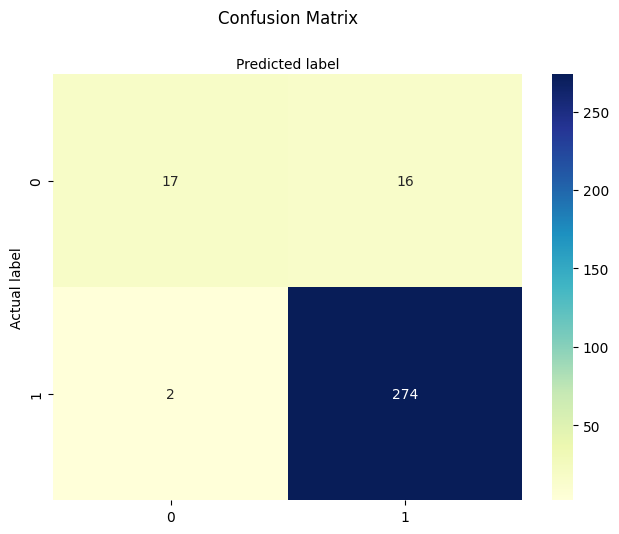

In [ ]:
# Print the metrics

print("\nAccuracy: %.5f " % (accuracy_score(y_test, y_pred)))

print(colored("\nClassification Report:", "red"))
print(classification_report(y_test,y_pred))

print(colored("Confusion Matrix:", "red"))
# Prepare the plot
fig, ax = plt.subplots()
tick_marks = np.arange(len(lr_classifier.classes_))
plt.xticks(tick_marks, lr_classifier.classes_)
plt.yticks(tick_marks, lr_classifier.classes_)

# Create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Save to pickle file
with open('lr_abstract_classifier', 'wb') as picklefile:
    pickle.dump(lr_classifier,picklefile)
